At the bottom of this notebook there is an interactive MXNet example. It Lets you vary the inputs with sliders and will compute outputs and gradients. You can even edit the network to make it more complex!

A video of this working is here: https://www.youtube.com/watch?v=-KmImwP5eGk
Joseph Paul Cohen 2016 (Code free for non-commercial use)

Version 2.0: This version lets you use arbitrary functions with any number of parameters!

In [1]:
import mxnet as mx
import cmath
import numpy as np

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [2]:
def compute(s=None, **kwargs):

    # get symbols to work with dynamically
    symbols = [k for k in kwargs.keys() if k != 's']
    args = dict([(k,mx.nd.array([kwargs[k]])) for k in symbols])
    shapes = dict([(k, args[k].shape) for k in symbols])
    
    sym = s.get_internals()
    blob_names = sym.list_outputs()
    sym_group = []
    for i in range(len(blob_names)):
        if blob_names[i] not in args:
            x = sym[i]
            if blob_names[i] not in sym.list_outputs():
                x = mx.symbol.BlockGrad(x, name=blob_names[i])
            sym_group.append(x)
    sym = mx.symbol.Group(sym_group)


    # Bind to symbol and create executor
    c_exec = sym.simple_bind(
                    ctx=mx.cpu(),
                    **shapes)

    # Copy input values into executor memory
    c_exec.copy_params_from(arg_params = args)

    # Perform computation forward to populate outputs
    c_exec.forward()

    values = []
    values = values + [(k,v.asnumpy()[0]) for k,v in zip(sym.list_arguments(),c_exec.arg_arrays)]
    values = values + [(k,v.asnumpy()[0]) for k,v in zip(sym.list_outputs(),c_exec.outputs)]

    # Bind to symbol and create executor
    c_exec = s.simple_bind(
                    ctx=mx.cpu(),
                    **shapes)

    # Copy input values into executor memory
    c_exec.copy_params_from(arg_params = args)

    # Perform computation forward to populate outputs
    c_exec.forward()

    # Backpropagate to calculate gradients 
    c_exec.backward(out_grads=mx.nd.array([1]))

    grads = []
    grads = grads + [(k,v.asnumpy()[0]) for k,v in zip(s.list_arguments(),c_exec.grad_arrays)]

    # Use these for debugging
    #for k,v in values: print("%20s=%.03f"% (k,v))
    #for k,v in grads: print("%20s=%.03f"% ("dout/d%s"%k,v))
    
    values_dict = dict(values)
    grads_dict = dict(grads)

    # Print computation graph of s.get_internals() because is shows more nodes
    a = plot_network2(sym, shape=shapes,
                            node_attrs={"shape":'rect',"fixedsize":'false'},
                     values_dict=values_dict, grads_dict=grads_dict)
    #Rotate the graphviz object that is returned
    a.body.extend(['rankdir=RL', 'size="10,5"'])

    del c_exec
    del sym
    
    #Show it. Use a.render() to write it to disk
    return a

In [3]:
## Here we define a new print network function

from __future__ import absolute_import
from mxnet.symbol import Symbol
import json
import re
import copy

def plot_network2(symbol, title="plot", shape=None, node_attrs={}, values_dict=None, grads_dict=None):
    try:
        from graphviz import Digraph
    except:
        raise ImportError("Draw network requires graphviz library")
    if not isinstance(symbol, Symbol):
        raise TypeError("symbol must be Symbol")
    draw_shape = False
    if shape != None:
        draw_shape = True
        interals = symbol.get_internals()
        _, out_shapes, _ = interals.infer_shape(**shape)
        if out_shapes == None:
            raise ValueError("Input shape is incompete")
        shape_dict = dict(zip(interals.list_outputs(), out_shapes))
    conf = json.loads(symbol.tojson())
    nodes = conf["nodes"]
    #print(conf)
    heads = set([x[0] for x in conf["heads"]])  # TODO(xxx): check careful
    #print(heads)
    # default attributes of node
    node_attr = {"shape": "box", "fixedsize": "true",
                 "width": "1.3", "height": "0.8034", "style": "filled"}
    # merge the dcit provided by user and the default one
    node_attr.update(node_attrs)
    dot = Digraph(name=title)
    dot.body.extend(['rankdir=RL', 'size="10,5"'])
    # color map
    cm = ("#8dd3c7", "#fb8072", "#ffffb3", "#bebada", "#80b1d3",
          "#fdb462", "#b3de69", "#fccde5")

    # make nodes
    for i in range(len(nodes)):
        node = nodes[i]
        op = node["op"]
        name = node["name"]
        # input data
        attr = copy.deepcopy(node_attr)
        label = op

        if op == "null":
            label = node["name"]
            if grads_dict != None and label in grads_dict:
                label = label + ("\n d%s: %.2f" % (label, grads_dict[label]))
            
        attr["fillcolor"] = cm[1]
        
        if op == "Convolution":
            label = "Convolution\n%sx%s/%s, %s" % (_str2tuple(node["param"]["kernel"])[0],
                                                   _str2tuple(node["param"]["kernel"])[1],
                                                   _str2tuple(node["param"]["stride"])[0],
                                                   node["param"]["num_filter"])
            attr["fillcolor"] = cm[1]
        elif op == "FullyConnected":
            label = "FullyConnected\n%s" % node["param"]["num_hidden"]
            attr["fillcolor"] = cm[1]
        elif op == "BatchNorm":
            attr["fillcolor"] = cm[3]
        elif op == "Activation" or op == "LeakyReLU":
            label = "%s\n%s" % (op, node["param"]["act_type"])
            attr["fillcolor"] = cm[2]
        elif op == "Pooling":
            label = "Pooling\n%s, %sx%s/%s" % (node["param"]["pool_type"],
                                               _str2tuple(node["param"]["kernel"])[0],
                                               _str2tuple(node["param"]["kernel"])[1],
                                               _str2tuple(node["param"]["stride"])[0])
            attr["fillcolor"] = cm[4]
        elif op == "Concat" or op == "Flatten" or op == "Reshape":
            attr["fillcolor"] = cm[5]
        elif op == "Softmax":
            attr["fillcolor"] = cm[6]
        else:
            attr["fillcolor"] = cm[0]

        dot.node(name=name, label=label, **attr)
    
    # add edges
    for i in range(len(nodes)):
        node = nodes[i]
        op = node["op"]
        name = node["name"]
        inputs = node["inputs"]
        for item in inputs:
            input_node = nodes[item[0]]
            input_name = input_node["name"]
            attr = {"dir": "back", 'arrowtail':'open'}
                
            label = ""
            if values_dict != None and input_name in values_dict:
                label = "%.2f" % values_dict[input_name]               
                
            if values_dict != None and input_name + "_output" in values_dict:
                label = "%.2f" % values_dict[input_name + "_output"]
                
            #if grads_dict != None and input_name in grads_dict:
            #    label = label + ("/%.2f" %grads_dict[input_name])
    
            attr["label"] = label.replace("_","")
            dot.edge(tail_name=name, head_name=input_name, **attr)
    return dot

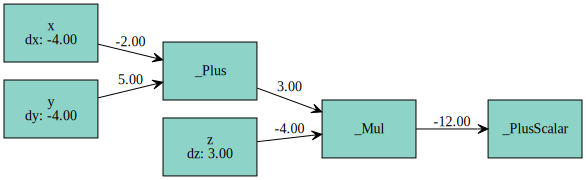

<function __main__.compute>

In [4]:
## Outputs from a node are shown on the edges and the gradients are shown in the box
## Modify the s object in compute different functions

# Declare input values in mxnet type
x = mx.symbol.Variable('x')
y = mx.symbol.Variable('y')
z = mx.symbol.Variable('z')

# Form expression using overloaded +,-,*, and / operators
# Use special mx methods to achieve other operations
s = ((x+y)*z)+0

# all the varables used in s need to be included as arguments here
interact(compute, s=fixed(s), x=-2, y=5, z=-4)

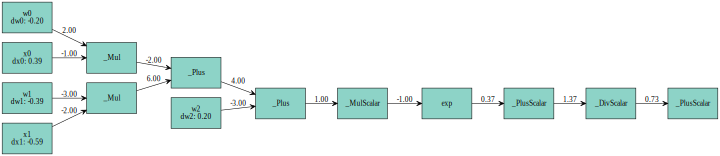

<function __main__.compute>

In [5]:
## Outputs from a node are shown on the edges and the gradients are shown in the box
## Modify the s object in compute different functions

# Declare input values in mxnet type
w0 = mx.symbol.Variable('w0') 
x0 = mx.symbol.Variable('x0') 
w1 = mx.symbol.Variable('w1') 
x1 = mx.symbol.Variable('x1') 
w2 = mx.symbol.Variable('w2')

# Form expression using overloaded +,-,*, and / operators
# Use special mx methods to achieve other operations

h = w0*x0 + w1*x1 + w2
s = 1/(1 + (mx.symbol.exp( -1*(h))))+0

# all the varables used in s need to be included as arguments here
interact(compute, s=fixed(s), w0=2, x0=-1, w1=-3, x1=-2, w2=-3)